# Doppler Shift

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from model import read_data, doppler_shift, filter_by_theta, get_spectra, plot_spectra

% matplotlib inline

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', size=30)

### Example

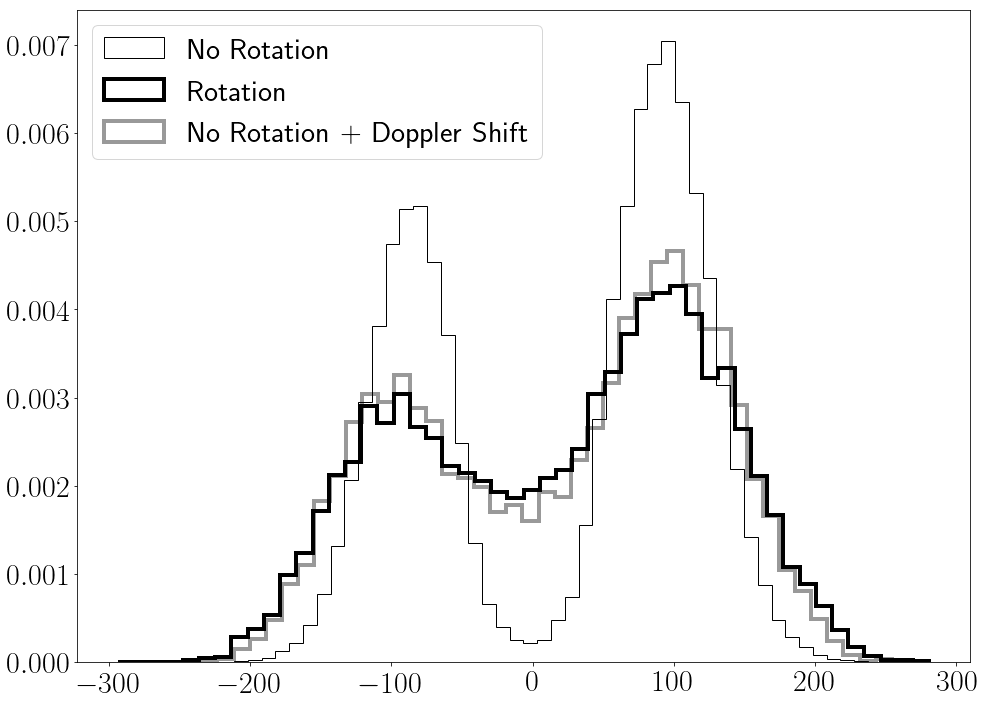

In [3]:
vrot = 100
vout = 5
logtau = 6
min_theta = np.pi/2.0 - 0.15
max_theta = np.pi/2.0

data_0 = read_data(0, vout, logtau)
x_0, y_0 = get_spectra(data_0, as_hist=False)

data_doppler = doppler_shift(data_0, vrot=vrot)
data_doppler_theta = filter_by_theta(data_doppler, min_theta, max_theta)
x_doppler, y_doppler = get_spectra(data_doppler_theta, as_hist=False)

data_clara = read_data(vrot, vout, logtau)
data_clara_theta = filter_by_theta(data_clara, min_theta, max_theta)
x_clara, y_clara = get_spectra(data_clara_theta, as_hist=False)

fig, ax = plt.subplots(figsize=(16,12))
plot_spectra(x_0, y_0, ax, lw=1, label='No Rotation')
plot_spectra(x_clara, y_clara, ax, lw=4, label='Rotation')
plot_spectra(x_doppler, y_doppler, ax, lw=4, alpha=0.4, label='No Rotation + Doppler Shift')
plt.legend(loc='upper left')
plt.show()

### Functions

In [4]:
def plot_doppler_grid(logtau, xmin=-150, xmax=200, ymin=0, ymax=0.0125, mint=np.pi/2.0-0.13, maxt=np.pi/2.0, labt=90):
    vrot0 = 0
    vrots = [50,100]
    vouts = [5,25,50]

    num_rows, num_cols = len(vouts), len(vrots)

    fig = plt.figure(1, figsize=(20, 20))
    grid = ImageGrid(fig, 111, # similar to subplot(111)
                     nrows_ncols = (num_rows, num_cols), # creates num_rows x num_cols grid of axes
                     axes_pad=0.3, # pad between axes in inch.
                     aspect=False,)
    props = dict(boxstyle='square', facecolor='white')

    i = 0 # grid cell number
    for vout in vouts:
        for vrot in vrots:
            
            data_0 = read_data(0, vout, logtau)
            x_0, y_0 = get_spectra(data_0, as_hist=False)

            data_doppler = doppler_shift(data_0, vrot=vrot)
            data_doppler_theta = filter_by_theta(data_doppler, mint, maxt)
            x_doppler, y_doppler = get_spectra(data_doppler_theta, as_hist=False)

            data_clara = read_data(vrot, vout, logtau)
            data_clara_theta = filter_by_theta(data_clara, mint, maxt)
            x_clara, y_clara = get_spectra(data_clara_theta, as_hist=False)

            grid_i = grid[i]
            
            grid_i.hist(x_0, weights=y_0, histtype='step', fill=False, normed=True, 
                        color='black', linewidth=1, bins=50, label='Outflows')
            grid_i.hist(x_clara, weights=y_clara, histtype='step', fill=False, normed=True, 
                        color='black', linewidth=4, bins=50, label='Outflows \n Rotation')
            grid_i.hist(x_doppler, weights=y_doppler, histtype='step', fill=False, normed=True, 
                        color='black', linewidth=4, alpha=0.4, bins=50, label='Outflows \n Doppler')

            if i == 4:
                grid_i.legend(loc=2)

            grid_i.set_xlim(xmin,xmax)
            grid_i.set_ylim(ymin,ymax)

            vout_lab = r'$v_{\mathrm{out}}=$ ' + '${0:.0f}$'.format(vout) + ' $\mathrm{km}$ $\mathrm{s^{-1}}$'
            vrot_lab = r'$v_{\mathrm{rot}}=$ ' + '${0:.0f}$'.format(vrot) + ' $\mathrm{km}$ $\mathrm{s^{-1}}$'

            if i <= 1:
                grid_i.text((xmin+xmax)/2, ymax*1.2, vrot_lab, bbox=props,
                            horizontalalignment='center', verticalalignment='center')
            if i%2 == 1:
                grid_i.text(xmax*1.2, (ymin+ymax)/2, vout_lab, bbox=props, rotation=270,
                            horizontalalignment='center', verticalalignment='center')
            if i == 2:
                grid_i.set_ylabel('$\mathrm{Intensity}$')
            if i == 4 or i == 5:
                grid_i.set_xlabel('$\mathrm{V}$ ($\mathrm{km}$ $\mathrm{s^{-1}}$)')

            i += 1

    plt.savefig('./results/doppler_shift_logtau'+str(logtau)+'_theta'+str(labt)+'.pdf', format='pdf', transparent=False, 
                bbox_inches='tight', pad_inches=0.2)
    plt.close()

### Figure: doppler_shift

In [5]:
# theta = 90
plot_doppler_grid(logtau=5)
plot_doppler_grid(logtau=6, xmin=-200, xmax=300, ymin=0, ymax=0.009)
plot_doppler_grid(logtau=7, xmin=-350, xmax=550, ymin=0, ymax=0.005)

In [6]:
# theta = 0
plot_doppler_grid(logtau=5, mint=0, maxt=0.51, labt=0)
plot_doppler_grid(logtau=6, xmin=-200, xmax=300, ymin=0, ymax=0.009, mint=0, maxt=0.51, labt=0)
plot_doppler_grid(logtau=7, xmin=-350, xmax=550, ymin=0, ymax=0.005, mint=0, maxt=0.51, labt=0)

In [7]:
a = np.linspace(1,0,9)
b = np.arccos(a)
b

array([ 0.        ,  0.50536051,  0.72273425,  0.89566479,  1.04719755,
        1.18639955,  1.31811607,  1.4454685 ,  1.57079633])

In [8]:
b[-1]-b[-2]

0.12532783116806523